In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML
import datetime as dt
import re

import numpy as np
import pandas as pd

from scipy.stats import gaussian_kde

# Slightly modified version of batic from (https://github.com/blab/baltic)
# Primary modification was to make variable date precision default for the decimalDate function
# Also needed to make a couple other changes to get collapseSubtree to work properly
import baltic_variable as bt

## For collapsing clades
from matplotlib.patches import Polygon
import matplotlib.patheffects as path_effects

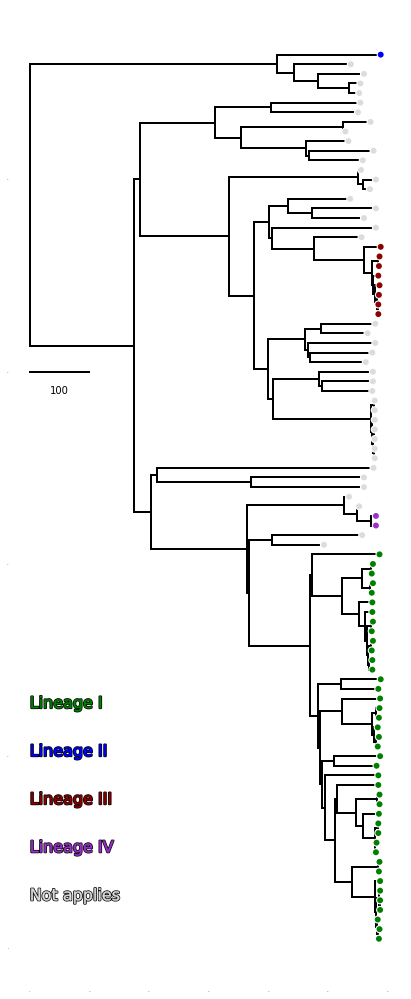

In [7]:
#####################################
####  Serovar-level ML Phylogeny ####
#####################################

#Read metadata
simple_meta = {"I":"Lineage I", 
               "II":"Lineage II",
               "III":"Lineage III",
               "IV":"Lineage IV", 
               "NA":"Not applies",
              }
md_path='/Users/Marcela/Documents/GitHub_files/Manus_abortus/MCCtree_metadata.txt'
fin = open(md_path, 'r')
lc=0
md_dict={}
for line in fin:
    lc+=1
    cols = line.strip().split("\t")
    if lc==1:
        name_idx = cols.index('name')
        color_idx = cols.index('broad_lin')
    if lc>1:
        md_dict[cols[name_idx]] = simple_meta[cols[color_idx]]
del(lc)


colors=["#DCDCDC", "#0000FF", "#8B0000", "#9932CC", "#008000"]


col_dict={}
col_count=0
for v in set(md_dict.values()):
    col_dict[v]=colors[col_count]
    col_count+=1

#Raxml-ng tree
tree_path='/Users/Marcela/Documents/GitHub_files/Manus_abortus/MCC_Figtree.nex'

fin = open(tree_path, 'r')
treeString = fin.read()
fin.close()

if tree_path[-4:] == ".nex": myTree = bt.loadNexus(tree_path, tip_regex=('\|([0-9]+)\|'),absoluteTime=False)
else:
    myTree = bt.tree()
    bt.make_tree(treeString, myTree)
myTree.traverse_tree()
myTree.sortBranches()

fig,ax = plt.subplots(figsize=(7,18),facecolor='w')
branchWidth=2 ## default branch width

#Generating legend for the colors
group=col_dict.keys()
for r,group in enumerate(sorted(group)[::-1]):
    effects=[path_effects.Stroke(linewidth=2, foreground='k'),
                 path_effects.Stroke(linewidth=0.5, foreground=col_dict[group])] ## colored text, black outline
    
    xpos=0.02
    resc=5
    ax.text(xpos,5+r*resc,'%s'%(group),size=16,color=col_dict[group],ha='left',path_effects=effects)
    
for k in myTree.Objects: ## iterate over objects in tree
    x=k.x ## 
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.x ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x

    #Plotting branch
    c='k'
    ec='w'
    #Plotting horizontal branches
    ax.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=8)
        
    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        s=35 ## tip size can be fixed
        ec='white'

        if isinstance(k,bt.leaf):  ## if branch is a leaf object
            c2=col_dict[md_dict[k.numName]]
            ax.scatter(x,y,s=s,facecolor=c2,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.9*s,facecolor=ec,edgecolor='none',zorder=10) ## plot another circle underneath
        else: ## it's actually a clade object
            c2 = 'black'
            clade=plt.Polygon(([x,y-0.0005*len(myTree.Objects)],[x,y+0.0005*len(myTree.Objects)],[k.lastHeight,y+k.width/2.0+0.5],[k.lastHeight,y-k.width/2.0+0.5]), facecolor = c2, edgecolor='none',zorder=12)
            ax.add_patch(clade)
            ax.text(k.lastHeight-.0003,y+0.5,k.numName.split()[0], color='w',ha='right',va='center', size=8, zorder=13)

            #Plot black circle if good posterior support
            if k.traits.has_key('bs100'):
                if k.traits['bs100'] >= 99:
                    ax.scatter(x,y,s=25,facecolor='k',edgecolor='none',zorder=13)        


            #For generating "bar graph metadata" for clades
            members=[]
            for each in k.subtree:
                if isinstance(each,bt.leaf): ## if leaf...
                    members.append(col_dict[md_dict[each.numName]])

            top = k.y+k.width/2+0.5
            for c in colors:
                if c in set(members):
                    ccount = members.count(c)
                    prop = float(ccount)/len(members)
                    lineage=plt.Rectangle((k.lastHeight,top-(k.width*prop)),0.0005,k.width*prop,facecolor=c,edgecolor='none') ## rectangle with height and width 1, at y position of tip and at the index of the key
                    ax.add_patch(lineage) ## add coloured rectangle to plot
                    top = top-(k.width*prop)

    
    
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #Plot vertical portions of branches
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=8)

        #Plot black circle if good bootstrap support
        if k.traits.has_key('bs100'):
            if k.traits['bs100'] >= 99:
                ax.scatter(x,y,s=25,facecolor='k',edgecolor='none',zorder=13)        
                

#Generate scale bar
start = 0
length = 100
ypos = 60
ax.plot([start,start+length],[ypos,ypos],lw=branchWidth,color='black',ls='-',zorder=8)
ax.text(start+(length/2),ypos-2,"%.f" % length,size=10,color='k',ha='center', va='center')


#Some formatting
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=0,size=0)
ax.tick_params(axis='y',labelsize=0,size=0)



#plt.savefig('/Users/Marcela/Documents/GitHub_files/Manus_abortus/Lineageid.png',dpi=200,bbox_inches='tight')
#plt.savefig('/Users/Marcela/Documents/GitHub_files/Manus_abortus/Lineageid.tiff',dpi=200,bbox_inches='tight')
plt.savefig('/Users/Marcela/Documents/GitHub_files/Manus_abortus/Lineageid.pdf',dpi=200,bbox_inches='tight')

{'Upper-Lin_II': 1, 'Upper-Lin_I': 5, 'Lower-Lin_IV': 3, 'state': 0, 'Lower-Lin_I': 2, 'Upper-Lin_III': 7, 'Upper-Lin_IV': 4, 'Lower-Lin_III': 6}
Upper-Lin_II 1845.079593
Upper-Lin_I 1797.03842
Lower-Lin_IV 2001.413285
Lower-Lin_I 1898.961078
Upper-Lin_III 1906.874975
Upper-Lin_IV 1978.26411
Lower-Lin_III 1990.028627
Upper-Lin_II = 1845.49: 1763.22 - 1905.80
Upper-Lin_III = 1907.18: 1851.35 - 1948.42
Lower-Lin_III = 1990.05: 1970.11 - 2004.60
Upper-Lin_I = 1796.03: 1709.61 - 1860.04
Lower-Lin_I = 1899.26: 1845.66 - 1944.10
Upper-Lin_IV = 1978.25: 1965.85 - 1982.00
Lower-Lin_IV = 2001.43: 1991.51 - 2007.81


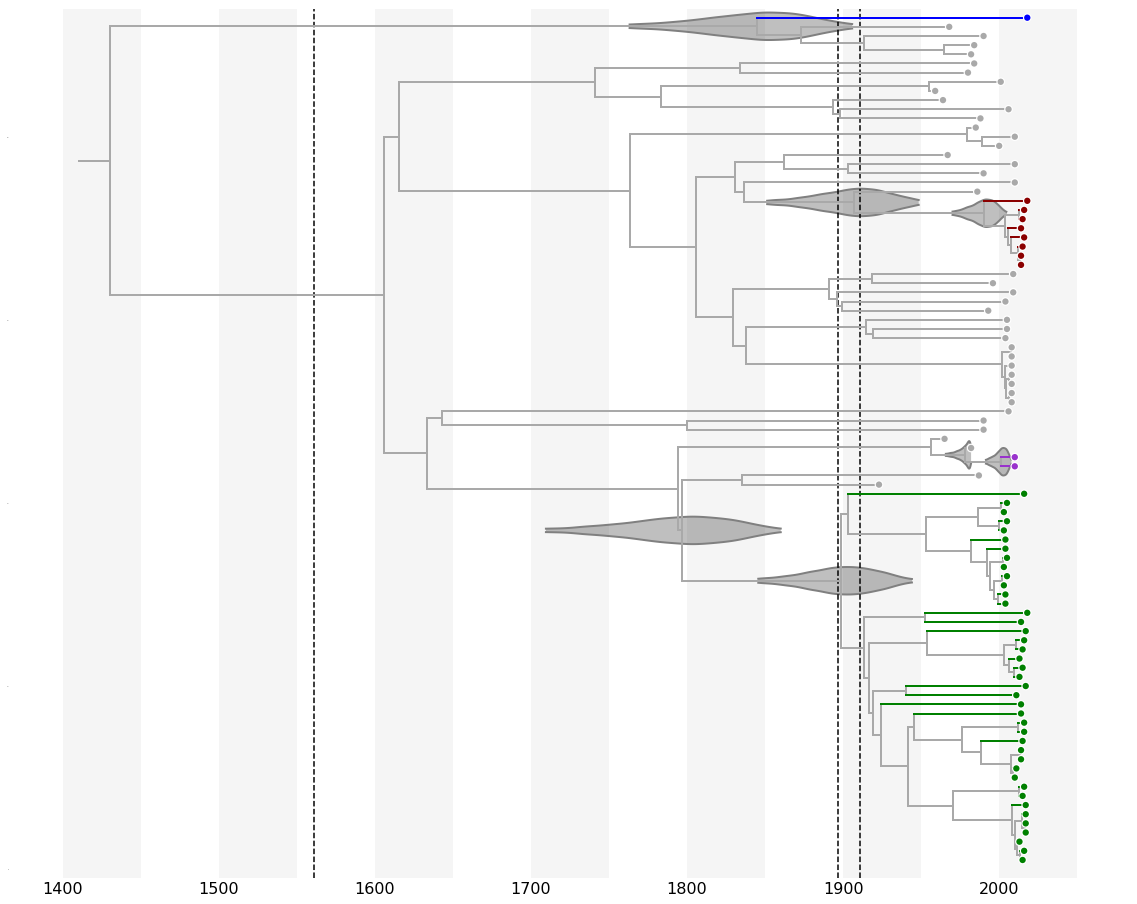

In [8]:
###########################
####  BEAST Phylogeny  ####
###########################

def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

def decimalDate(date,fmt="%Y-%m-%d",variable=False,dateSplitter='-'):
    """ Converts calendar dates in specified format to decimal date. """
    
    if variable==True:
        unknowns=date.count(dateSplitter)

        if unknowns==1:
            #date=dateSplitter.join(date.split(dateSplitter)[:-1])
            fmt=dateSplitter.join(fmt.split(dateSplitter)[:-1])
            precision=1/12.0
        elif unknowns==0:
            #date=dateSplitter.join(date.split(dateSplitter)[:-2])
            fmt=dateSplitter.join(fmt.split(dateSplitter)[:-2])
            precision=1.0
        elif unknowns==2:
            precision=None
    else:
        precision=None
    
    #print '>%s<'%(date)
    
    adatetime=dt.datetime.strptime(date,fmt) ## convert to datetime object
    year = adatetime.year ## get year
    boy = dt.datetime(year, 1, 1) ## get beginning of the year
    eoy = dt.datetime(year + 1, 1, 1) ## get beginning of next year
    return (year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds())),precision) ## return fractional year


#Read metadata
simple_meta = {"I":"Lineage I", 
               "II":"Lineage II",
               "III":"Lineage III",
               "IV":"Lineage IV", 
               "NA":"Not applies",
              }

colors=["#A9A9A9", "#0000FF", "#8B0000", "#9932CC", "#008000"]
col_count=0
for v in set(simple_meta.values()):
    col_dict[v]=colors[col_count]
    col_count+=1

    
#median node heights
tree_path='/Users/Marcela/Documents/GitHub_files/Manus_abortus/MCC_Figtree.nex'
ll=bt.loadNexus(tree_path, tip_regex='\|([0-9]+)\|')

clades={'Lower-Lin_I':['11983_1_28|2013|Costa_Rica|Human','baboCR111_S7|2015|Costa_Rica|Bovine','11983_1_29|2013|Costa_Rica|Human','baboCR150_S12|2016|Costa_Rica|Bovine','baboCR92_S5|2015|Costa_Rica|Bovine','baboCR189_S14|2017|Costa_Rica|Bovine','babohCR168|2017|Costa_Rica|Human','14913_1_8|2011|Costa_Rica|Bovine','14913_1_11|2014|Costa_Rica|Unknown','baboCR75_S1|2014|Costa_Rica|Bovine','baboCR137_S11|2016|Costa_Rica|Bovine','babohCR176_S17|2016|Costa_Rica|Human','baboCR112_S8|2015|Costa_Rica|Bovine','14913_1_1|2014|Costa_Rica|Bovine','14913_1_2|2014|Costa_Rica|Bovine','11983_1_34|2010|Costa_Rica|Bovine','11983_1_33|2011|Costa_Rica|Bovine','babohCR180_S15|2015|Costa_Rica|Human','babohCR174_S18|2016|Costa_Rica|Human','babohCR181_S5|2013|Costa_Rica|Human','babohCR179|2015|Costa_Rica|Human','babohCR177_S14|2016|Costa_Rica|Human','babohCR195_S16|2017|Costa_Rica|Human','babohCR196_S7|2017|Costa_Rica|Human','babohCR175|2017|Costa_Rica|Human','babohCR178_S6|2017|Costa_Rica|Human','baboCR209_S17|2018|Costa_Rica|Buffalo','14913_1_7|2014|Costa_Rica|Human','11983_1_82|2003|Costa_Rica|Bovine','12045_3_51|2005|Costa_Rica|Bovine','11983_1_30|2003|Costa_Rica|Bovine','12673_8_3|2005|Costa_Rica|Bovine','11940_5_95|2004|Costa_Rica|Bovine','11983_1_52|2003|Costa_Rica|Bovine','11983_1_47|2005|Costa_Rica|Bovine','11502_1_18|2004|Costa_Rica|Bovine','11983_1_79|2004|Costa_Rica|Bovine','11983_1_58|2003|Costa_Rica|Bovine','11983_1_41|2005|Costa_Rica|Bovine','11983_1_38|2004|Costa_Rica|Bovine','baboCR136_S10|2016|Costa_Rica|Bovine'],
        'Upper-Lin_I':['B_abortus_87-2211|1987|USA|Bovine','B_abortus_S19|1923|USA|Bovine','11983_1_28|2013|Costa_Rica|Human','baboCR111_S7|2015|Costa_Rica|Bovine','11983_1_29|2013|Costa_Rica|Human','baboCR150_S12|2016|Costa_Rica|Bovine','baboCR92_S5|2015|Costa_Rica|Bovine','baboCR189_S14|2017|Costa_Rica|Bovine','babohCR168|2017|Costa_Rica|Human','14913_1_8|2011|Costa_Rica|Bovine','14913_1_11|2014|Costa_Rica|Unknown','baboCR75_S1|2014|Costa_Rica|Bovine','baboCR137_S11|2016|Costa_Rica|Bovine','babohCR176_S17|2016|Costa_Rica|Human','baboCR112_S8|2015|Costa_Rica|Bovine','14913_1_1|2014|Costa_Rica|Bovine','14913_1_2|2014|Costa_Rica|Bovine','11983_1_34|2010|Costa_Rica|Bovine','11983_1_33|2011|Costa_Rica|Bovine','babohCR180_S15|2015|Costa_Rica|Human','babohCR174_S18|2016|Costa_Rica|Human','babohCR181_S5|2013|Costa_Rica|Human','babohCR179|2015|Costa_Rica|Human','babohCR177_S14|2016|Costa_Rica|Human','babohCR195_S16|2017|Costa_Rica|Human','babohCR196_S7|2017|Costa_Rica|Human','babohCR175|2017|Costa_Rica|Human','babohCR178_S6|2017|Costa_Rica|Human','baboCR209_S17|2018|Costa_Rica|Buffalo','14913_1_7|2014|Costa_Rica|Human','11983_1_82|2003|Costa_Rica|Bovine','12045_3_51|2005|Costa_Rica|Bovine','11983_1_30|2003|Costa_Rica|Bovine','12673_8_3|2005|Costa_Rica|Bovine','11940_5_95|2004|Costa_Rica|Bovine','11983_1_52|2003|Costa_Rica|Bovine','11983_1_47|2005|Costa_Rica|Bovine','11502_1_18|2004|Costa_Rica|Bovine','11983_1_79|2004|Costa_Rica|Bovine','11983_1_58|2003|Costa_Rica|Bovine','11983_1_41|2005|Costa_Rica|Bovine','11983_1_38|2004|Costa_Rica|Bovine','baboCR136_S10|2016|Costa_Rica|Bovine'],
        'Lower-Lin_III':['baboCR202_S15|2018|Costa_Rica|Buffalo','baboCR123_S9|2015|Costa_Rica|Bovine','baboCR79B_S3|2014|Costa_Rica|Bovine','baboCR77B_S2|2014|Costa_Rica|Bovine','baboCR156_S13|2016|Costa_Rica|Bovine','baboCR82_S4|2014|Costa_Rica|Bovine','baboCR100_S6|2015|Costa_Rica|Bovine','babohCR182_S8|2016|Costa_Rica|Human'],
        'Upper-Lin_III':['B_abortus_87-0095|1986|USA|Bovine','baboCR202_S15|2018|Costa_Rica|Buffalo','baboCR123_S9|2015|Costa_Rica|Bovine','baboCR79B_S3|2014|Costa_Rica|Bovine','baboCR77B_S2|2014|Costa_Rica|Bovine','baboCR156_S13|2016|Costa_Rica|Bovine','baboCR82_S4|2014|Costa_Rica|Bovine','baboCR100_S6|2015|Costa_Rica|Bovine','babohCR182_S8|2016|Costa_Rica|Human'],
        'Lower-Lin_IV':['12673_8_2|2010|Costa_Rica|Bovine','12673_8_1|2010|Costa_Rica|Bovine'],
        'Upper-Lin_IV':['B_abortus_82-2330|1982|USA|Reindeer','12673_8_2|2010|Costa_Rica|Bovine','12673_8_1|2010|Costa_Rica|Bovine'],
       'Upper-Lin_II':['baboCR203_S16|2018|Costa_Rica|Buffalo']
       }


tmrcas={c:[] for c in clades.keys()}



log_path='/Users/Marcela/Documents/GitHub_files/Manus_abortus/abCR_Upper-lower-CRclades.log'
#Adjust as appropriate
burnin=0
for line in open(log_path,'r'):
    l=line.strip('\n').split('\t')
    if l[0]=='state':
        header=l
        idx={x:i for i,x in enumerate(header)}
        print idx
    elif int(l[0])>burnin:
        for ca in tmrcas.keys():
            tmrcas[ca].append(float(l[idx['%s'%(ca)]]))

for ca in clades.keys():
    anc=ll.commonAncestor(clades[ca])
    anc.traits['clade']=ca
    print ca,anc.absoluteTime

fig,ax = plt.subplots(figsize=(20,16),facecolor='w')
branchWidth=2 ## default branch width

cmap=mpl.cm.viridis
order=[k.numName for k in ll.traverse_tree()]

plotTree=ll.Objects

for k in plotTree: ## iterate over objects in tree
    x=k.absoluteTime ## 
    y=k.y ## get y position from .drawTree that was run earlier, but could be anything else
    xp=k.parent.absoluteTime ## get x position of current object's parent
    if x==None: ## matplotlib won't plot Nones, like root
        x=0.0
    if xp==None:
        xp=x-20

    #Plotting branches
    c='k'
    ec='w'
    c2 = "grey"
    #Plotting horizontal branches
    if isinstance(k,bt.leaf):  ## if branch is a leaf object
            c2=col_dict[md_dict[k.numName]]
            ax.plot([xp,x],[y,y],lw=branchWidth,color=c2,ls='-',zorder=8)
    else:
            c2='#A9A9A9'
            ax.plot([xp,x],[y,y],lw=branchWidth,color=c2,ls='-',zorder=8)

    if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
        s=40 ## tip size can be fixed
        ec='white'

        if isinstance(k,bt.leaf):  ## if branch is a leaf object
            c2=col_dict[md_dict[k.numName]]
            ax.scatter(x,y,s=s,facecolor=c2,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=s+0.9*s,facecolor=ec,edgecolor='none',zorder=10) ## plot another circle underneath
        else: ## it's actually a clade object
            c2 = 'black'
            clade=plt.Polygon(([x,y-0.0005*len(myTree.Objects)],[x,y+0.0005*len(myTree.Objects)],[k.lastHeight,y+k.width/2.0+0.5],[k.lastHeight,y-k.width/2.0+0.5]), facecolor = c2, edgecolor='none',zorder=12)
            ax.add_patch(clade)
            ax.text(k.lastHeight-.0003,y+0.5,k.numName.split()[0], color='w',ha='right',va='center', size=8, zorder=13)

            #Plot black circle if good posterior support
            if k.traits.has_key('bs100'):
                if k.traits['bs100'] >= 99:
                    ax.scatter(x,y,s=25,facecolor='k',edgecolor='none',zorder=13)        
                
    elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
        #Plot vertical portions of branches
        ax.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c2,ls='-',zorder=8)

        #Plot background black circle
        if k.traits.has_key('posterior'):
            if k.traits['posterior'] >= 0.95:
                ax.scatter(x,y,s=25,facecolor='k',edgecolor='none',zorder=9)        

                
       #Plot kde distribution, for select nodes
        if k.traits.has_key('clade'):
            tmrca_dist=tmrcas[k.traits['clade']]
            switch=np.median(tmrca_dist)
            kde=gaussian_kde(tmrca_dist)
            hpdLo,hpdUp=hpd(tmrca_dist,0.95)
            x_grid=np.linspace(hpdLo,hpdUp,100)

            print "%s = %.2f: %.2f - %.2f" % (k.traits['clade'], switch, hpdLo,hpdUp)
            
            y_grid=kde.evaluate(x_grid)
            y_grid=y_grid/y_grid.max()

            up=[y+w*1.5 for w in y_grid]
            lo=[y-w*1.5 for w in y_grid]
            ax.fill_between(x_grid,up,lo,facecolor='grey',edgecolor='none',alpha=0.5,zorder=1)
            ax.plot(x_grid,up,lw=2,color='grey')
            ax.plot(x_grid,lo,lw=2,color='grey')
                

ax.set_ylim(-1,1+len([w for w in plotTree if w.branchType=='leaf']))


xDates=[]
every=50
#xDates+=['%04d'%(y) for y in range(-5000,2030,every)]
xDates+=[y for y in range(1400,2040,every)]
#print xDates

fmt='%Y'

#ax.set_xlim(xDates[0],2030.0)

#Drawing vertical lines
#[ax.axvline(x,color='grey') for x in range(1400,2040, 50)]
[ax.axvline(x,linestyle='--',color='black') for x in (1561,1897,1911)]

#Drawing alternating grey/white vertical blocks (really just drawing the grey blocks)
[ax.axvspan(xDates[x],xDates[x]+every,facecolor='k',edgecolor='none',alpha=0.04) for x in range(0,len(xDates),2)]

#Set x-axis tick label positions
ax.set_xticks([x+1/24.0 for x in xDates if x%100==0])
#Set x-axis tick labels
ax.set_xticklabels([x for x in xDates if x%100==0])
#ax.set_xticklabels([convertDate(x,'%Y-%m-%d',fmt) if x.split('-')[1]=='01' else convertDate(x,'%Y-%m-%d','%b') for x in xDates if (int(x.split('-')[1])-1)%every==0])

#Some more formatting
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis='x',labelsize=16,size=0)
ax.tick_params(axis='y',labelsize=0,size=0)

#plt.savefig('%s/Users/Marcela/Documents/GitHub_files/Manus_abortus/BEASTphylogeny-HPD.png' % gdrive_path,dpi=200,bbox_inches='tight')
#plt.savefig('%/Users/Marcela/Desktop/BEASTphylogeny.tiff' % gdrive_path,dpi=200,bbox_inches='tight')
plt.savefig('/Users/Marcela/Documents/GitHub_files/Manus_abortus/BEASTphylogeny-HPD.pdf',dpi=200,bbox_inches='tight')
